In [1]:
import tqdm
import cv2
import os

import pandas as pd
import numpy as np

import platform
import random
import time
import imageio

import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from IPython.display import clear_output

from sklearn.model_selection import StratifiedShuffleSplit

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D, Add, add,InputLayer, Input, MaxPooling2D,AveragePooling2D, GlobalAveragePooling2D, MaxPool2D, ZeroPadding2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import concatenate
from tensorflow.keras.applications import DenseNet121


from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau



import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)

In [3]:
print("Working Platform is :", platform.platform())

Working Platform is : Linux-5.15.89+-x86_64-with-debian-bullseye-sid


In [4]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [5]:
imagePath = '../input/skincancer/Datasets/Train/JPG/'
train_imagePath = '../input/skincancer/Datasets/Train/JPG/'
test_imagePath = '../input/skincancer/Datasets/Test/JPG/'

In [6]:
train_dataframe = pd.read_csv("../input/skincancer/Datasets/ISIC_2020_Training_GroundTruth.csv")

In [7]:
len(train_dataframe)

33126

In [8]:
train_dataframe.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [9]:
train_dataframe.columns

Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target'],
      dtype='object')

In [10]:
os.path.join(imagePath, train_dataframe['image_name'][0]+".jpg")

'../input/skincancer/Datasets/Train/JPG/ISIC_2637011.jpg'

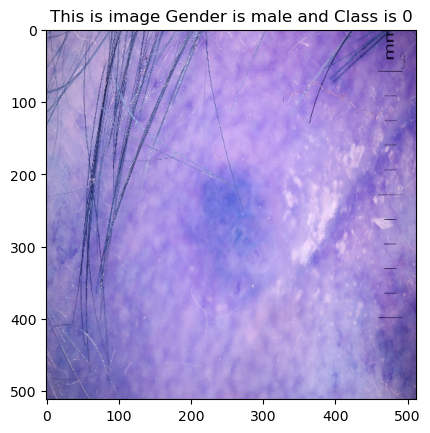

In [11]:


img = cv2.imread(os.path.join(os.path.join(imagePath, train_dataframe['image_name'][0]+".jpg")))
img = cv2.resize(img, (512, 512))
plt.title("This is image Gender is {} and Class is {}".format(train_dataframe['sex'][0], train_dataframe['target'][0]))
plt.imshow(img)
plt.show()

In [12]:
benign = []
malignant = []

for i in range(len(train_dataframe)):
    if train_dataframe['target'][i] == 0:
        benign.append(train_dataframe['image_name'][i]+'.jpg')
    else:
        malignant.append(train_dataframe['image_name'][i]+'.jpg')

In [13]:
print("Length of Benign Datasets is : ",len(benign))
print("Length of Malignant Datasets is : ",len(malignant))

Length of Benign Datasets is :  32542
Length of Malignant Datasets is :  584


In [14]:
train_image_data = train_imagePath
test_image_data  = test_imagePath

In [15]:
# image_map = []
# def prepareData(Dir):
#     for img in tqdm(os.listdir(Dir)):
#         image_Path = img
#         if image_Path in benign:
#             image_map.append({"Path":os.path.join(Dir, image_Path), 
#                          "label":"Benign"})
#         else:
#             image_map.append({"Path":os.path.join(Dir, image_Path), 
#                          "label":"Malignant"})

In [16]:
image_map = []
def prepareData(Dir):
    for img in tqdm(os.listdir(Dir)):
        image_Path = img
        if image_Path in benign:
            image_map.append({"Path":os.path.join(Dir, image_Path), 
                         "label":str(0)})
        else:
            image_map.append({"Path":os.path.join(Dir, image_Path), 
                         "label":str(1)})

In [17]:
prepareData(train_imagePath)

100%|██████████| 33126/33126 [00:09<00:00, 3504.61it/s]


In [18]:
prepareData(test_imagePath)

100%|██████████| 10982/10982 [00:06<00:00, 1826.04it/s]


In [19]:
image_map = pd.DataFrame(image_map).sample(frac = 1, random_state = seed)

In [20]:
image_map.head()

,Path,label
37886,../input/skincancer/Datasets/Test/JPG/ISIC_543...,1
4128,../input/skincancer/Datasets/Train/JPG/ISIC_16...,0
3031,../input/skincancer/Datasets/Train/JPG/ISIC_50...,1
38068,../input/skincancer/Datasets/Test/JPG/ISIC_387...,1
25695,../input/skincancer/Datasets/Train/JPG/ISIC_47...,0


In [21]:
def printImages(samples):
    image = samples["Path"].to_numpy()
    labels = samples["label"].to_numpy()
    
    fig = plt.figure(figsize=(20, 8))
    columns = 4
    rows = 1
    
    for i, imagePaths in enumerate(image):
        image = cv2.imread(imagePaths, cv2.IMREAD_COLOR)
        
        fig.add_subplot(rows, columns, i+1)
        title = "{}".format(labels[i])
        
        sample_image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
        plt.imshow(sample_image, cmap = "gray")
        plt.title(title)
        
    plt.show()

In [22]:
printImages(image_map[image_map["label"]==0].iloc[0:4])
plt.show()

<Figure size 2000x800 with 0 Axes>

In [23]:
printImages(image_map[image_map["label"]==1].iloc[0:4])
plt.show()

<Figure size 2000x800 with 0 Axes>

In [24]:
def getLabelsCount(frame):
    label_count = frame['label'].value_counts()
    return label_count

In [25]:
getLabelsCount(image_map)

0    32542
1    11566
Name: label, dtype: int64

In [26]:
features = image_map["Path"].to_numpy()
labels = image_map["label"].to_numpy()

In [27]:
stratified_samples = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 42)

In [28]:
for train_index, test_index in stratified_samples.split(features, labels):
    X_train, X_test = features[train_index], labels[test_index]
    Y_train, Y_test = labels[train_index], features[test_index]

In [29]:
half_size = len(X_test)//2

In [30]:
x_test, y_test = X_test[0:half_size], Y_test[0:half_size]
X_val, Y_val =  X_test[half_size:], Y_test[half_size:]

In [31]:
train_map = pd.DataFrame()
train_map["Path"] = X_train
train_map["label"] = Y_train

In [32]:
Y_train

array(['1', '1', '0', ..., '0', '0', '0'], dtype=object)

In [33]:
train_map.head()

,Path,label
0,../input/skincancer/Datasets/Test/JPG/ISIC_563...,1
1,../input/skincancer/Datasets/Test/JPG/ISIC_957...,1
2,../input/skincancer/Datasets/Train/JPG/ISIC_54...,0
3,../input/skincancer/Datasets/Train/JPG/ISIC_83...,0
4,../input/skincancer/Datasets/Train/JPG/ISIC_77...,0


In [34]:
test_map = pd.DataFrame()
test_map["Path"] = Y_test
test_map["label"] = X_test

In [35]:
val_map = pd.DataFrame()
val_map["Path"] = Y_val
val_map["label"] = X_val

In [36]:
print("Train Data Size: {}".format(len(train_map)))
print("Test Data Size: {}".format(len(test_map)))
print("Validation Data Size: {}".format(len(val_map)))

Train Data Size: 35286
Test Data Size: 8822
Validation Data Size: 4411


In [37]:
colorch = 3
image_size = 224
input_shape = (image_size, image_size, colorch)

In [38]:
classes = ['Benign', 'Malignant']
categories = sorted(classes)
print("Classes: ", categories)

Classes:  ['Benign', 'Malignant']


In [39]:
datagen = ImageDataGenerator(rescale = 1./255, 
                            horizontal_flip = True, 
                            brightness_range = [1.0, 1.3],
                             rotation_range = 15)

In [40]:
batch_size = 64

In [41]:
def get_generator(frame_):
    generator = datagen.flow_from_dataframe(dataframe = frame_,
                                           x_col = "Path",
                                           y_col = 'label', 
                                           batch_size=batch_size,
                                           seed = seed,
                                           shuffle = False,
                                           class_mode = 'binary', 
                                           color_mode ='rgb', 
                                           save_format = 'jpg', 
                                           target_size = (image_size, image_size))
    return generator

In [42]:
train_df = train_map.sample(frac = 1, random_state = 42)
train_generator = get_generator(train_df)

print("label Count for Train Datasets: ")
getLabelsCount(train_df)

Found 35286 validated image filenames belonging to 2 classes.
label Count for Train Datasets: 


0    26033
1     9253
Name: label, dtype: int64

In [43]:
test_df = test_map.sample(frac = 1, random_state = 42)
test_generator = get_generator(test_df)

print("label Count for Test Datasets: ")
getLabelsCount(test_df)

Found 8822 validated image filenames belonging to 2 classes.
label Count for Test Datasets: 


0    6509
1    2313
Name: label, dtype: int64

In [44]:
val_df = val_map.sample(frac = 1, random_state = 42)
val_generator = get_generator(val_df)

print("label Count for Validation Datasets: ")
getLabelsCount(val_df)

Found 4411 validated image filenames belonging to 2 classes.
label Count for Validation Datasets: 


0    3252
1    1159
Name: label, dtype: int64